# Installations

In [2]:
pip install numpy pandas sklearn matplotlib seaborn yellowbrick

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Projects\Algorithms\LinearRegression\linearRegression\Scripts\python.exe -m pip install --upgrade pip' command.


# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import residuals_plot, prediction_error, CooksDistance
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# EDA

### Data Exploration

In [5]:
df.shape

(1338, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Changing children to categorical feature

In [9]:
df = df.astype({'children' : 'object'})
df.dtypes

age           int64
sex          object
bmi         float64
children     object
smoker       object
region       object
charges     float64
dtype: object

### Visualization

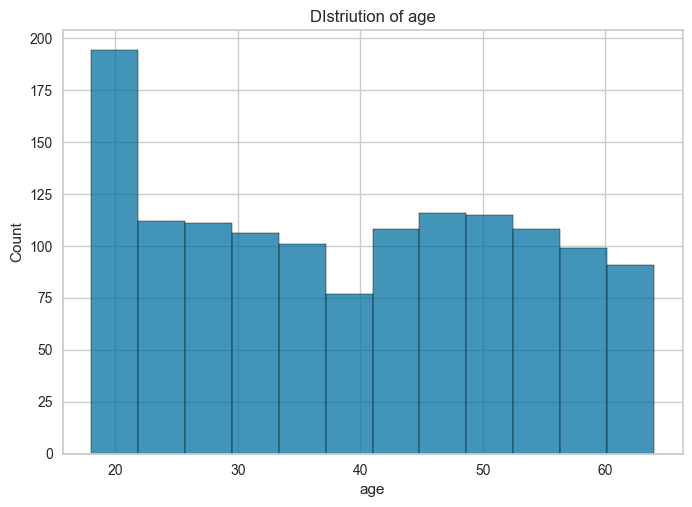

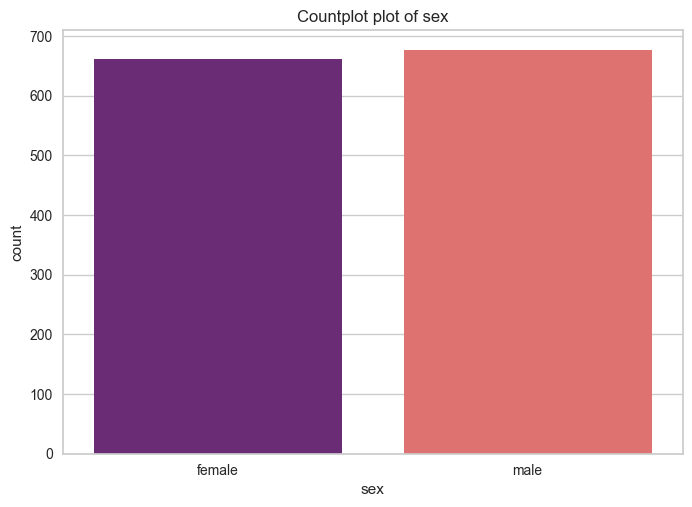

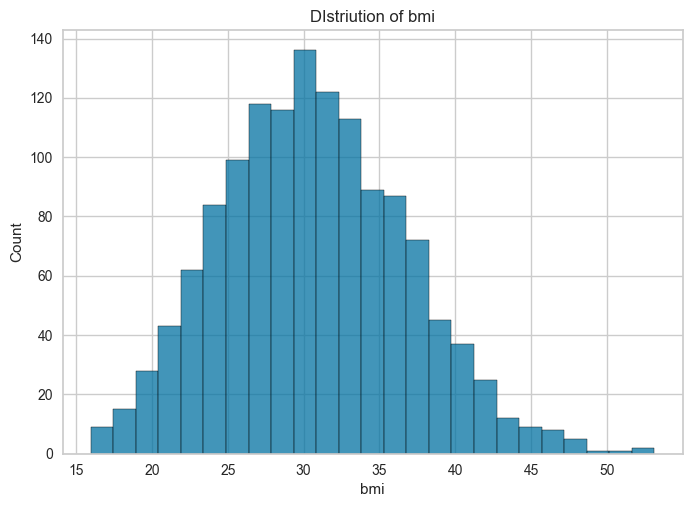

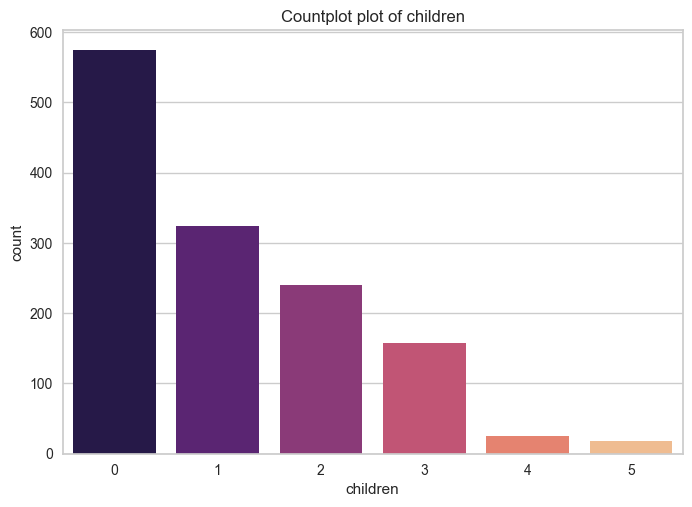

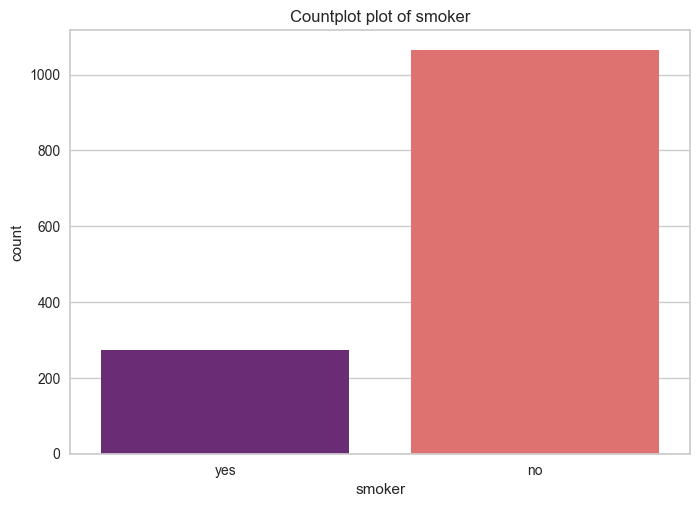

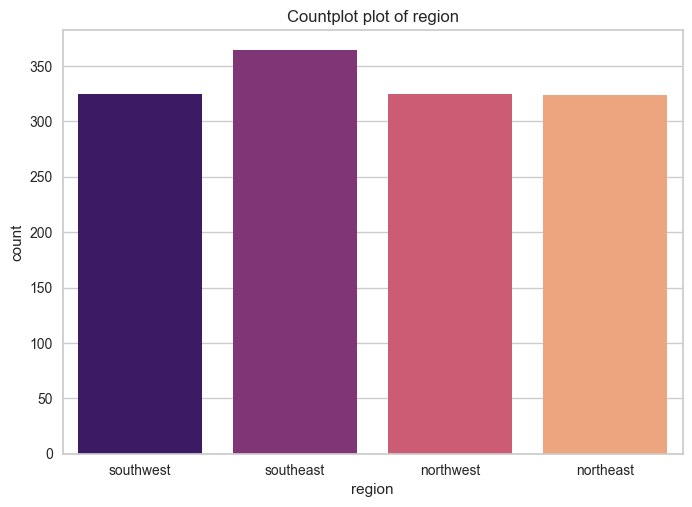

In [10]:
# Distribution of Features
for col in df.columns:
    if (col == 'charges'):
        continue
    if (df[col].dtype != 'object'):
        sns.histplot(x=col, data=df)
        plt.title("Distribution of " + col)
        plt.show()
    else :
        sns.countplot(x=col, data=df, palette='magma')
        plt.title("Countplot of " + col)
        plt.show()

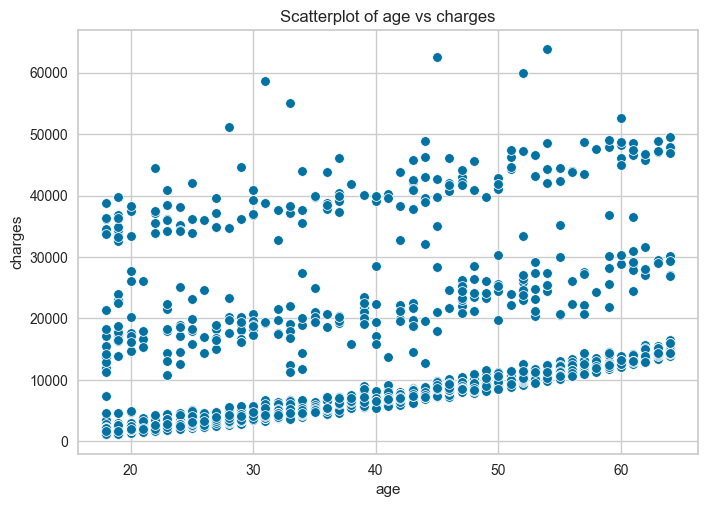

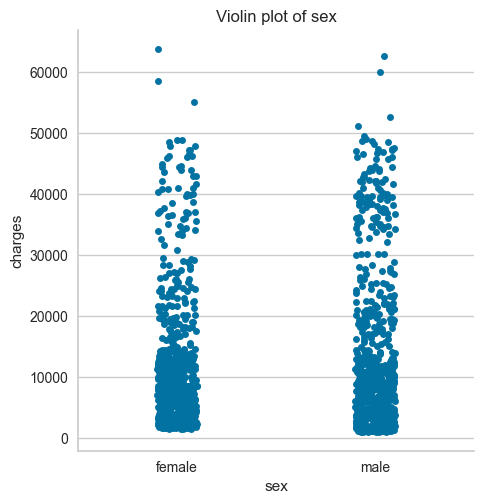

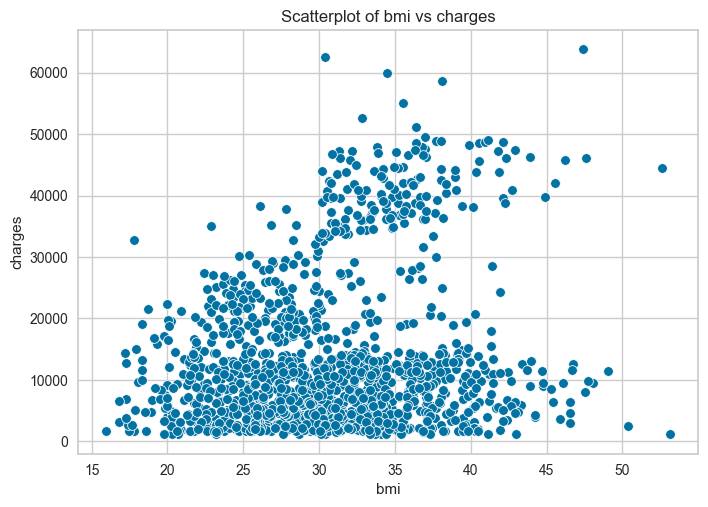

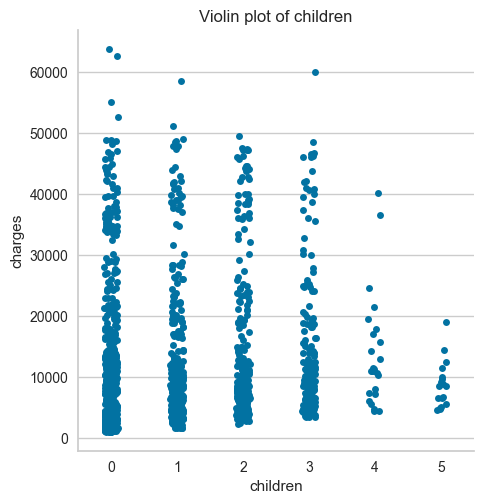

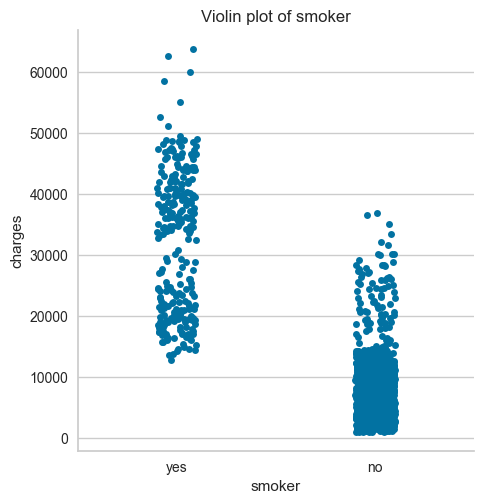

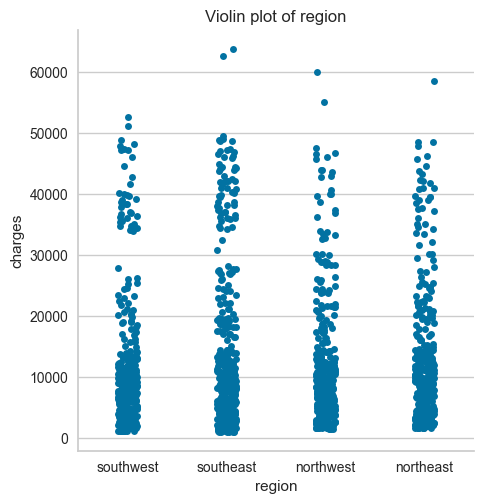

In [11]:
# Plotting input features against target variable
for col in df.columns:
    if (col == 'charges'):
        continue
    if (df[col].dtype != 'object'):
        sns.scatterplot(x=col, y='charges', data=df)
        plt.title("Scatterplot of " + col + " vs charges")
        plt.show()
    else :
        sns.catplot(x=col, y='charges', data=df)
        plt.title("Cat plot of " + col + " vs charges")
        plt.show()

Looks like there are some clustering when in the age and bmi plot. Let's examine

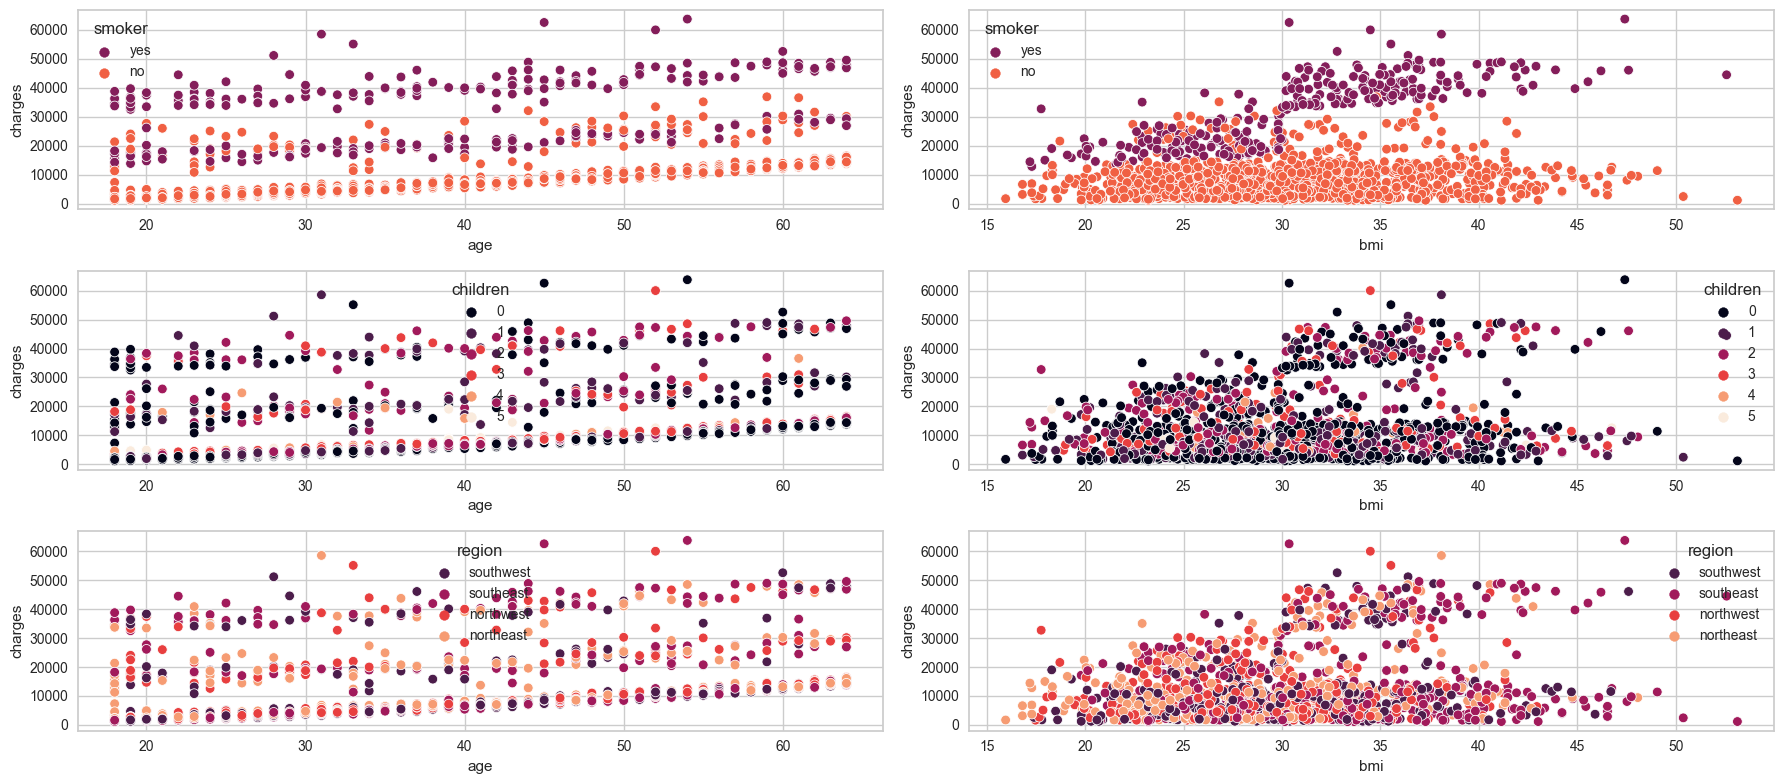

In [32]:
# Plotting age & bmi vs charges with hue as categorical features
i = 1
f = plt.figure(figsize=(18,8))
for col in ['smoker', 'children', 'region']:
    ax = f.add_subplot(3,2,i)
    ax = sns.scatterplot(x='age', y='charges', data=df, hue=col, palette='rocket')
    i = i+1
    ax = f.add_subplot(3,2,i)
    x = sns.scatterplot(x='bmi', y='charges', data=df, hue=col, palette='rocket')
    i = i+1
    plt.tight_layout()

There's not much clustering when it comes to region and children, but there are clear clusters when smoker feature is involved

In [13]:
# Checking Skewness
df[df.select_dtypes(exclude='object').columns].skew()

age        0.055673
bmi        0.284047
charges    1.515880
dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

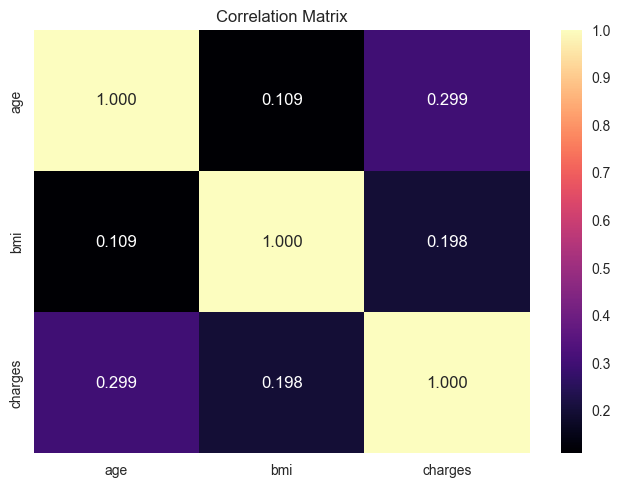

In [14]:
# Correlation Matrix
sns.heatmap(df.corr(), annot=True, cmap='magma', fmt = '0.3f')
plt.title('Correlation Matrix')

# Feature Engineering

### Analysis

Since we are observing clusters when taking the smoker category into account, we'll split the data depending on the smoker feature and conduct further analysis.

In [15]:
no_smoker_df = df.query("smoker == 'no'")
smoker_df = df.query("smoker == 'yes'")   

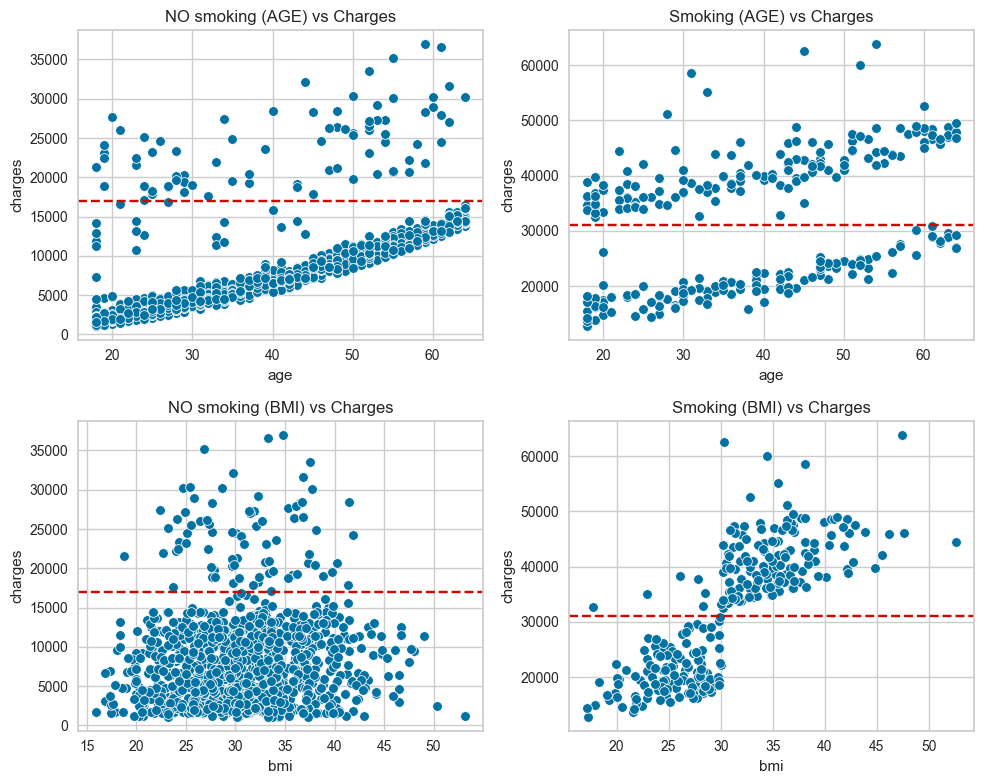

In [16]:
f = plt.figure(figsize=(10,8))
ax1 = f.add_subplot(221)
ax1 = sns.scatterplot(x='age', y='charges', data=no_smoker_df)
plt.axhline(y=17000, color='r', linestyle="--")
plt.title("NO smoking (AGE) vs Charges")

ax2 = f.add_subplot(222)
ax2 = sns.scatterplot(x='age', y='charges', data=smoker_df)
plt.axhline(y=31000, color='r', linestyle="--")
plt.title("Smoking (AGE) vs Charges")

ax1 = f.add_subplot(223)
ax1 = sns.scatterplot(x='bmi', y='charges', data=no_smoker_df)
plt.axhline(y=17000, color='r', linestyle="--")
plt.title("NO smoking (BMI) vs Charges")

ax2 = f.add_subplot(224)
ax2 = sns.scatterplot(x='bmi', y='charges', data=smoker_df)
plt.axhline(y=31000, color='r', linestyle="--")
plt.title("Smoking (BMI) vs Charges")

plt.tight_layout()

After splitting the smoking and non-smoking population, we can see 2 trends in both the cases. We can create a new feature - **health_condition** where we categorize them based on charges - good or bad - depending on whether they lie above or below the marked line.

### Creating new feature - health_condition

In [17]:
def feature_extraction(df):
    no_smoker_df = df.query("smoker == 'no'")
    smoker_df = df.query("smoker == 'yes'")

    no_smoker_df['health_condition'] = no_smoker_df['charges'].apply(lambda x : "bad" if x > 17000 else "good")
    smoker_df['health_condition'] = smoker_df['charges'].apply(lambda x : "bad" if x > 31000 else "good")

    ret = pd.concat([no_smoker_df, smoker_df])
    return ret

In [18]:
# Creating a new dataframe with the new feature
df1 = feature_extraction(df)

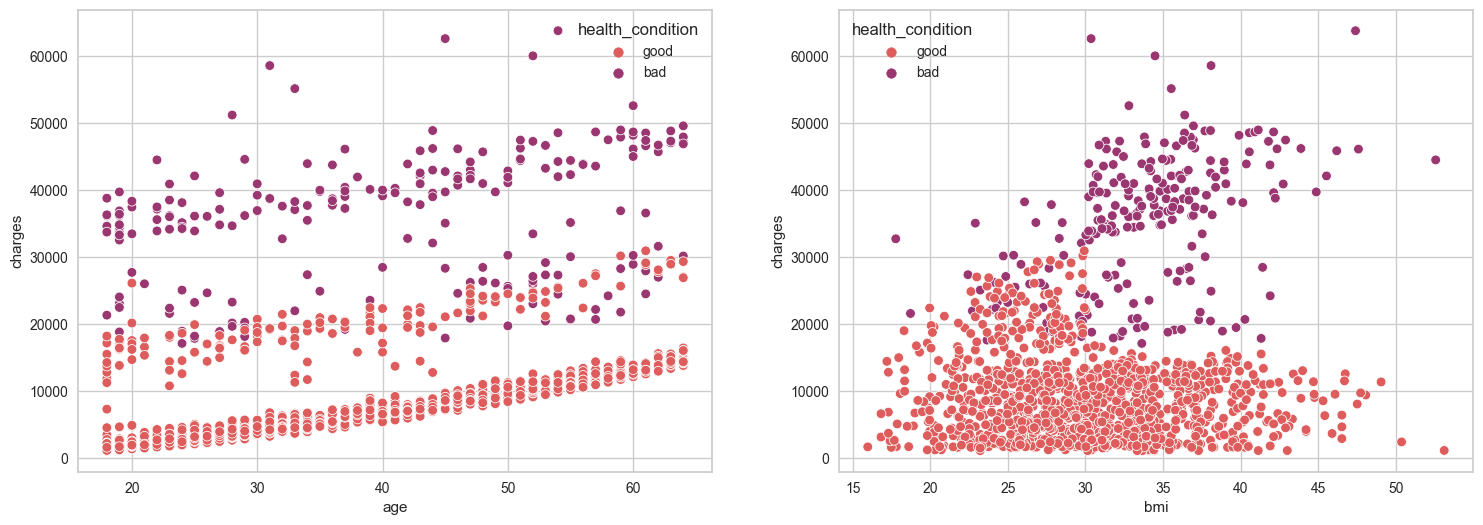

In [19]:
# Plotting age & bmi vs charges with hue as health_condition
f = plt.figure(figsize=(18,6))
ax1 = f.add_subplot(121)
ax1 = sns.scatterplot(x='age', y='charges', hue='health_condition', data=df1, palette="flare")
ax2 = f.add_subplot(122)
ax2 = sns.scatterplot(x='bmi', y='charges', hue='health_condition', data=df1, palette="flare")

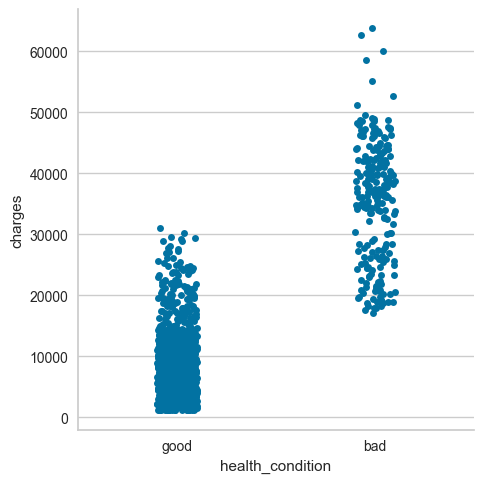

In [20]:
# Plotting health_condition vs charges
sns.catplot(x='health_condition', y='charges', data=df1)

Now you can see clear clusters in the plot, where having bad health condition results in higher charges. 

# Splitting Dataset

In [21]:
def data_splitting(df):
    X = df.drop(['charges'],axis=1)
    y = df.charges

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
    return X_train, X_test, y_train, y_test

# Encoding

In [22]:
def encoding(df):
    df = pd.get_dummies(df, drop_first=True)
    return df

# Scaling Data

In [23]:
def scaling(X_train, X_test):
    
    scaler = StandardScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    return X_train, X_test


# Modeling and Evaluation

In [24]:
def modeling_and_evaluation(df):
    
    # Creating a new copy
    df_copy = df.copy()

    # Encoding the data
    df_copy = encoding(df_copy)

    # Splitting into train and test sets
    X_train, X_test, y_train, y_test = data_splitting(df_copy)

    # Scaling the input features
    X_train_scaled, X_test_scaled = scaling(X_train, X_test) 

    # Fitting the model
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # Predicting using train and test data
    train_predict = lr_model.predict(X_train_scaled)
    test_predict = lr_model.predict(X_test_scaled)

    print("Results ------------------------------ \n")

    mse_train = mean_squared_error(y_train, train_predict)
    mse_test = mean_squared_error(y_test, test_predict)
    r2_train = r2_score(y_train, train_predict)
    r2_test = r2_score(y_test, test_predict)

    # Adjusted r2 score
    n = X_test.shape[0]
    p = X_test.shape[1]

    adj_r2_train = 1-(1-r2_train)*(n-1)/(n-p-1)
    adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)

    print("Train Data Performance ------------")
    print("R2 score for training data - {0}".format(r2_train))
    print("Adjusted R2 score for training data - {0}".format(adj_r2_train))
    print("MSE for training data - {0}".format(mse_train))

    print("\nTest Data Performance ------------")
    print("R2 score for testing data - {0}".format(r2_test))
    print("Adjusted R2 score for testing data - {0}".format(adj_r2_test))
    print("MSE for testing data - {0}".format(mse_test))

    # Checking for generalization and overfitting using metrics
    # Difference percentage in train and test errors
    diff_mse = np.round(np.abs((((mse_test - mse_train) / mse_train) * 100)), 2)
    print("\nDifference% in the MeanSquaredError between training and test datasets is - {0}%".format(diff_mse))

    if (diff_mse < 10):
        print("Difference% is < 10. Generalizes well with less Overfitting")
    else :
        print("Difference% is > 10. Doesn't generalizes well. Overfitting prevalent")

    plt.figure(figsize=(15,5))
    plt.barh(X_test.columns, np.abs(lr_model.coef_))
    plt.title("Linear Regression Coefficients")

Results ------------------------------ 

Train Data Performance ------------
R2 score for training data - 0.7486438664081898
Adjusted R2 score for training data - 0.7368153424744576
MSE for training data - 36660022.20705435

Test Data Performance ------------
R2 score for testing data - 0.7632007319189736
Adjusted R2 score for testing data - 0.7520572369504548
MSE for testing data - 35349546.198352404

Difference% in the MeanSquaredError between training and test datasets is - 3.57%
Difference% is < 10. Generalizes well with less Overfitting


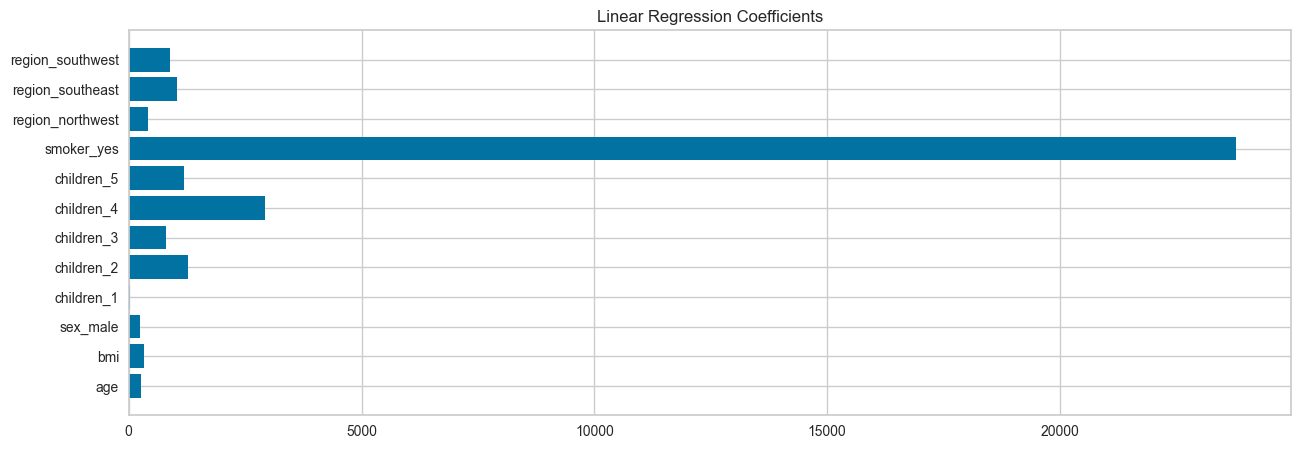

In [25]:
# Modeling without the health_condition feature
modeling_and_evaluation(df)

Results ------------------------------ 

Train Data Performance ------------
R2 score for training data - 0.9630604248762483
Adjusted R2 score for training data - 0.9611698167006233
MSE for training data - 5250477.806515013

Test Data Performance ------------
R2 score for testing data - 0.9706364480011728
Adjusted R2 score for testing data - 0.9691335890406029
MSE for testing data - 4813862.784147304

Difference% in the MeanSquaredError between training and test datasets is - 8.32%
Difference% is < 10. Generalizes well with less Overfitting


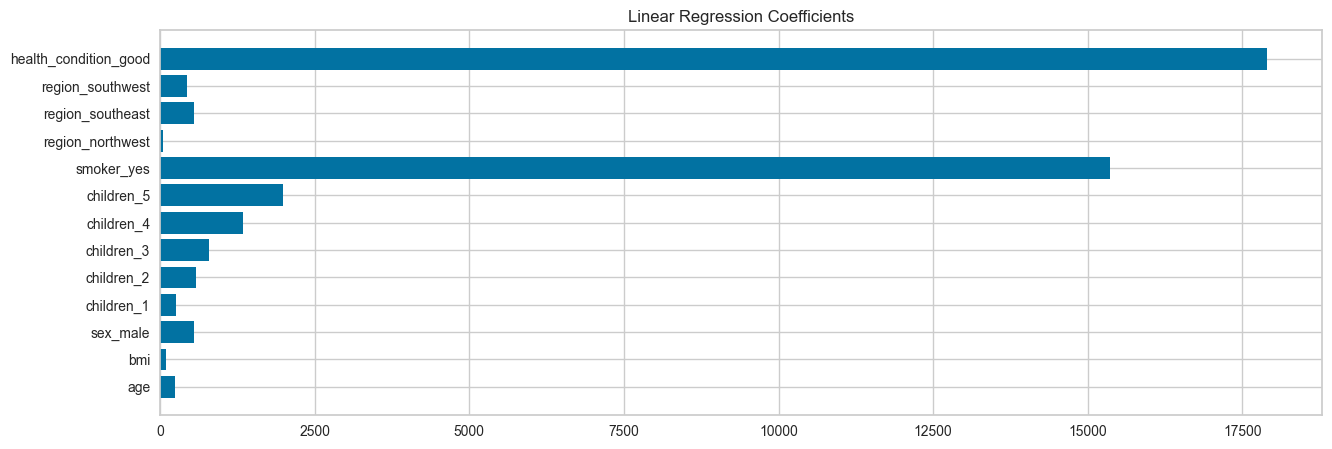

In [26]:
# Modeling using the health_condition feature
modeling_and_evaluation(df1)

*Conclusions*:
- Adding a new feature - **health_condition** drastically increases the performance. 
- R2 score increases from around ~0.75 to ~0.96.
- Though the difference in mse increases (from 3.6% to 8.3%) which might suggest that there is slight increase in overfitting, it is still just low and permissible. 

# Residual Analysis

In [27]:
def residual_analysis(df):
    model = LinearRegression()
    df_copy = df.copy()
    df_copy = encoding(df_copy)
    X_train, X_test, y_train, y_test = data_splitting(df_copy)
    X_train_scaled, X_test_scaled = scaling(X_train, X_test) 

    residuals_plot(model, X_train_scaled, y_train, X_test_scaled, y_test)
    prediction_error(model, X_train_scaled, y_train, X_test_scaled, y_test)
    
    X = df_copy.drop(['charges'], axis=1)
    y = df_copy.charges
    visualizer = CooksDistance()
    visualizer.fit(X, y)
    visualizer.show()

    print("----------------------------------- After Outlier Removal -----------------------------------")

    i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
    X_li, y_li = X[i_less_influential], y[i_less_influential]

    X_train, X_test, y_train, y_test = train_test_split(X_li, y_li, test_size=0.2, shuffle=True, random_state=1)
    X_train_scaled, X_test_scaled = scaling(X_train, X_test)
    residuals_plot(model, X_train_scaled, y_train, X_test_scaled, y_test)
    prediction_error(model, X_train_scaled, y_train, X_test_scaled, y_test)
    visualizer = CooksDistance()
    visualizer.fit(X_li, y_li)
    visualizer.show()

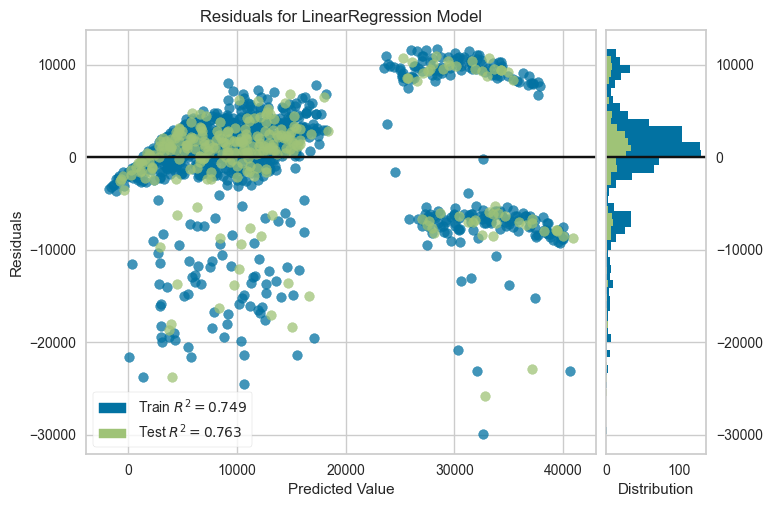

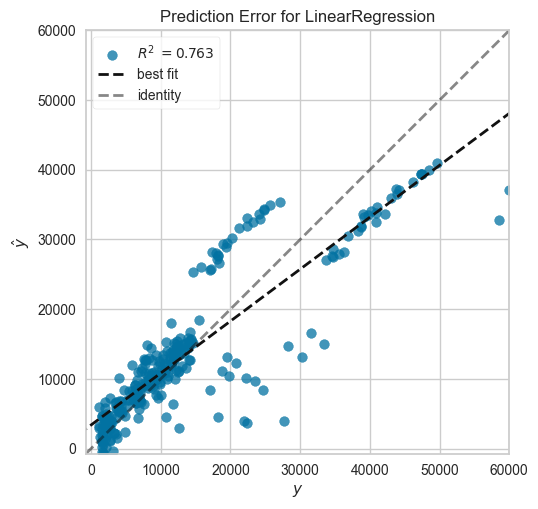

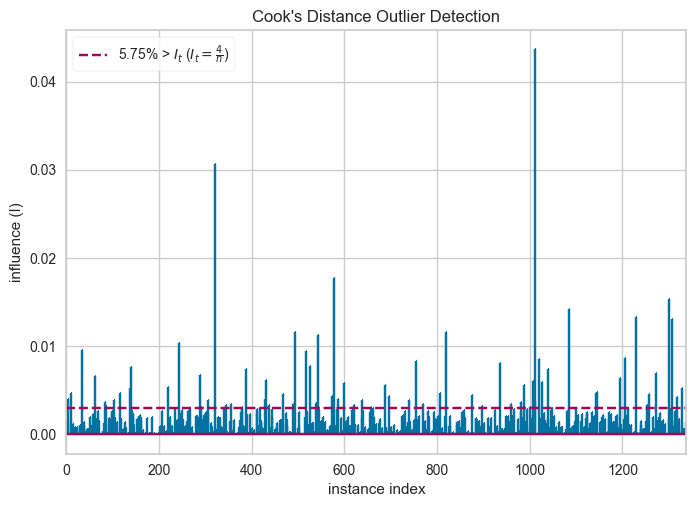

After Outlier Removal


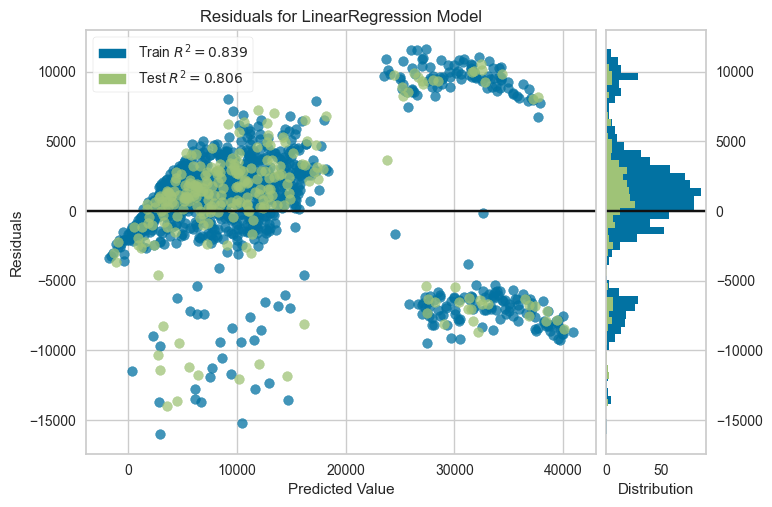

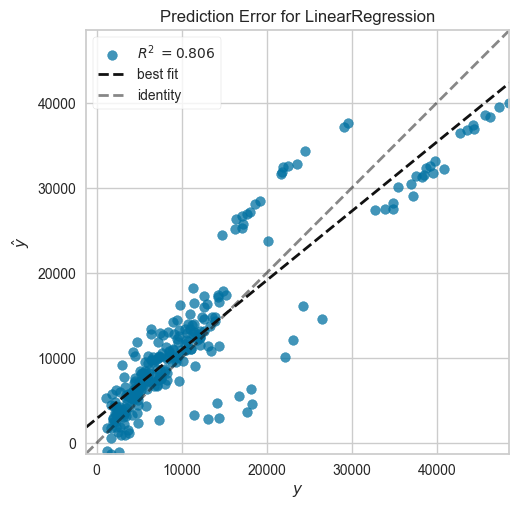

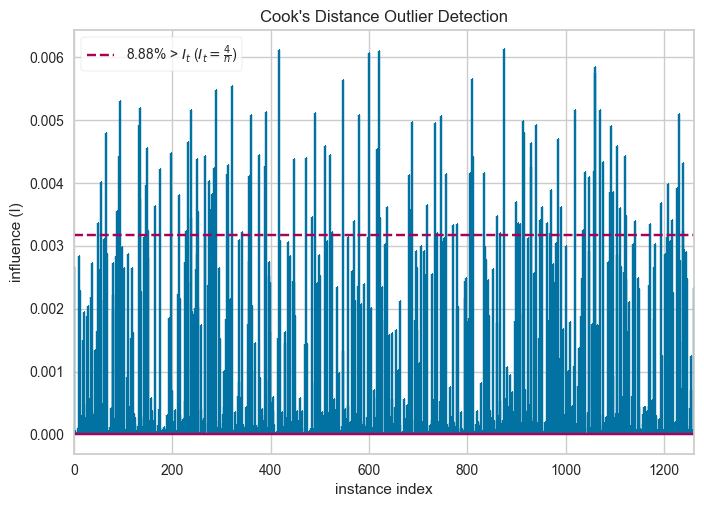

In [28]:
residual_analysis(df)

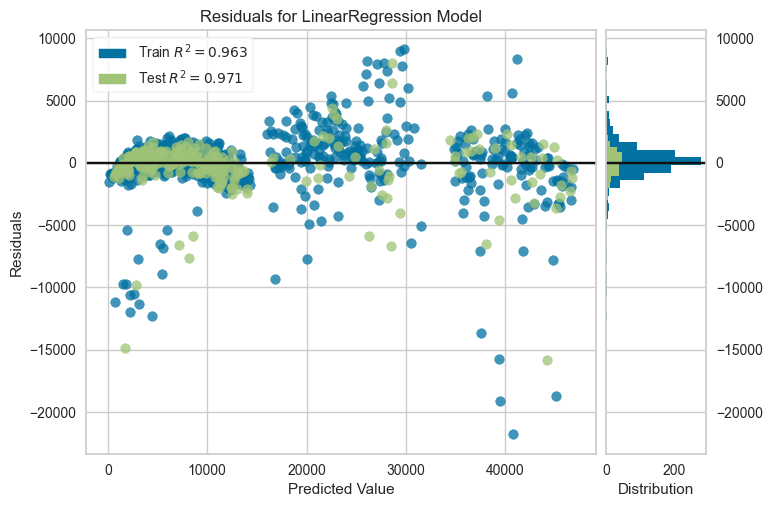

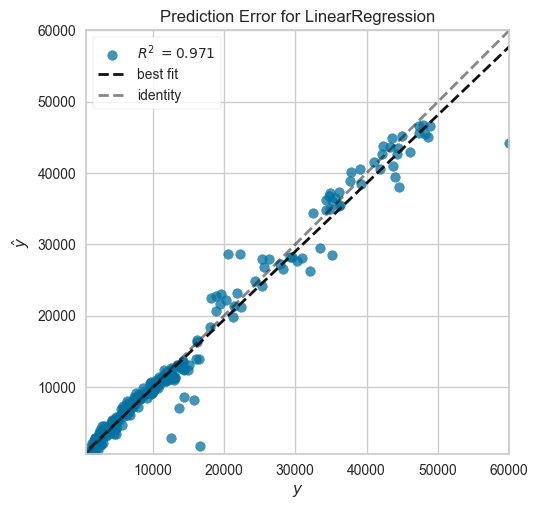

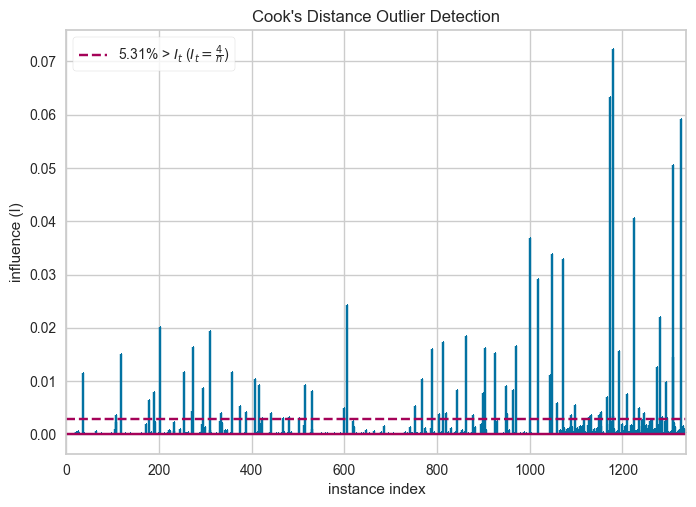

After Outlier Removal


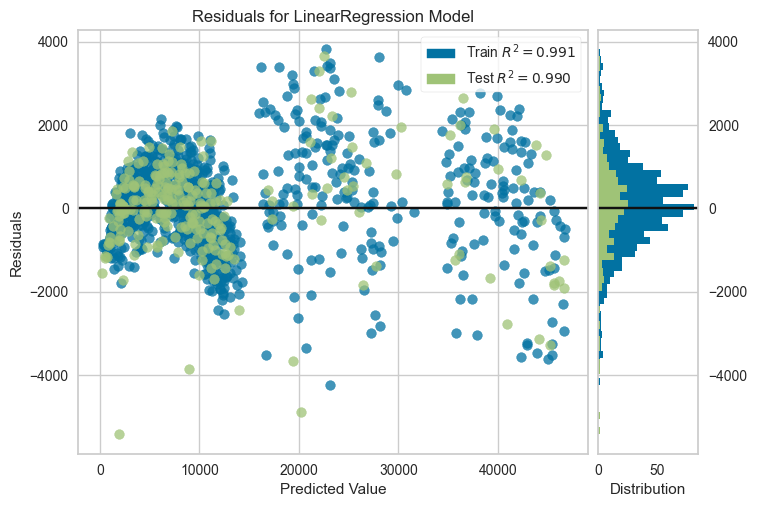

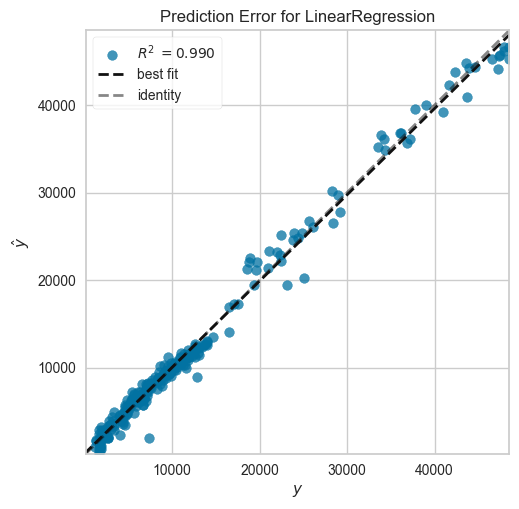

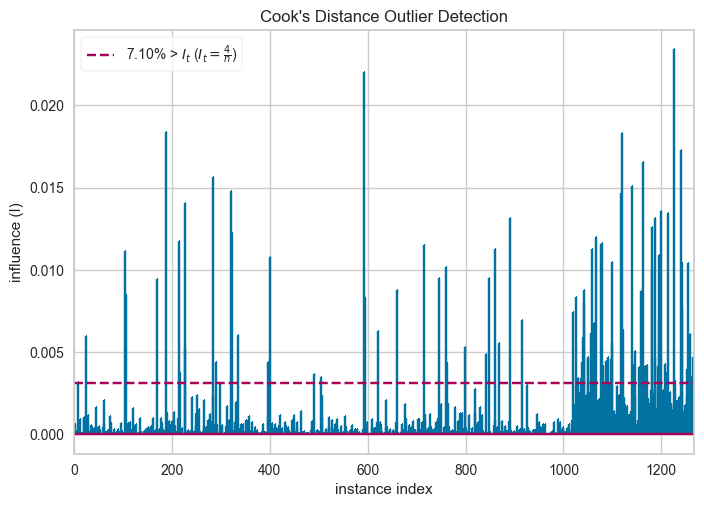

In [29]:
residual_analysis(df1)

*Conclusions*:
- Adding a new feature is doing wonders - as evident from the performance and evaluation of the df1 dataset.
- From the residual analysis we find that there are a few patterns in the plot (heteroscedastic), but it seems normalized around 0. 
- Removing the outliers, increased the homoscedasticity and R2 score.
- Still patterns persist, which might be due to the smaller dataset size.